In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import numpy as np
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
seed = 0
mnist_img_size = (28,28)
def init_MLP(layer_widths,parent_key, scale=0.01):

  params = []
  keys = jax.random.split(parent_key, num=len(layer_widths)-1)

  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append(
        [scale*jax.random.normal(weight_key, shape=(out_width, in_width)), 
         scale*jax.random.normal(bias_key, shape=(out_width,))]
                  )
  return params

key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784,512,256,10],key)

print(jax.tree_map(lambda x:x.shape,MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [3]:
def MLP_predict(params, x):
  # computing the forward pass for each example individually
  hidden_layers = params[:-1]

  activation = x
  # loop over the Relu hidden layers
  for w, b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation)+b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, activation)+b_last

  return logits - logsumexp(logits)

batched_MLP_predict = vmap(MLP_predict, in_axes=(None,0))

# small test
dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(16, 784)
(16, 10)


In [4]:
# todo: adding data loading in PyTorch
def custom_transform(x):
  return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
  transposed_data = list(zip(*batch))

  labels = np.array(transposed_data[1])
  imgs = np.array(transposed_data[0])
  return imgs,labels


train_dataset = MNIST(root='train_mnist', train=True, download= True, transform=custom_transform)
# testing the transformation
print(type(train_dataset))
something = train_dataset[0]
print(type(something[0]))

# as we see we are working with jax neither PyTorch nor tensorflow 
#then we have to transform the images in dataset into numpy array from this PIL.image

test_dataset = MNIST(root='test_mnist', train= False, download= True, transform = custom_transform )
batch_size = 128
img = train_dataset[0][0]
print(img.shape)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, sampler=None,collate_fn= custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw

<class 'torchvision.datasets.mnist.MNIST'>
<class 'numpy.ndarray'>


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(784,)
(128, 784) float32 (128,) int64


In [5]:
# todo: add the training loop, loss function

num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.24133705
0.095240295
0.05919378
0.04607613
0.035330165
0.035348307
0.036922563
0.037483938
0.029690152
0.029313657
Epoch 0, train acc = 0.9121833443641663 test acc = 0.914199948310852
0.037459433
0.031475242
0.03003261
0.034568
0.01885475
0.03513835
0.026392132
0.020849729
0.038195755
0.030731618
Epoch 1, train acc = 0.9347333312034607 test acc = 0.9353999495506287
0.01963012
0.02578854
0.016099257
0.016382834
0.020438617
0.02301991
0.021495758
0.024980158
0.017727748
0.0059038145
Epoch 2, train acc = 0.9460999965667725 test acc = 0.9429999589920044
0.024081094
0.019741634
0.024497477
0.014553952
0.021104326
0.034933437
0.033051547
0.0149188405
0.012902944
0.014759205
Epoch 3, train acc = 0.9518333673477173 test acc = 0.9490999579429626
0.011104695
0.014038694
0.012079248
0.015037045
0.019898176
0.020274516
0.014942283
0.020336438
0.013995714
0.02010195
Epoch 4, train acc = 0.959600031375885 test acc = 0.9545999765396118


(28, 28)
pred 2
gt 2


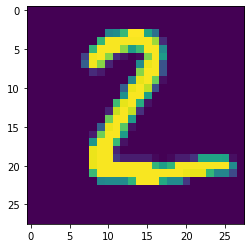

In [6]:
imgs, lbls = next(iter(test_loader))
img = imgs[1].reshape(mnist_img_size)
gt_lbl = lbls[1]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()